<a href="https://colab.research.google.com/github/haesongism/haes_coder/blob/main/20221109_ML_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
import seaborn as sns

## 데이터 불러오기

In [ ]:
# https://archive.ics.uci.edu/ml/datasets/wine
# https://www.kaggle.com/datasets/akhil0007/wine-data
file_url = 'https://raw.githubusercontent.com/bigdata-young/bigdata_16th/main/data/wine.csv'
df = pd.read_csv(file_url)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Class                 178 non-null    int64  
 1   Alcohol               178 non-null    float64
 2   Malic_Acid            178 non-null    float64
 3   Ash                   178 non-null    float64
 4   Ash_Alcanity          178 non-null    float64
 5   Magnesium             178 non-null    int64  
 6   Total_Phenols         178 non-null    float64
 7   Flavanoids            178 non-null    float64
 8   Nonflavanoid_Phenols  178 non-null    float64
 9   Proanthocyanins       178 non-null    float64
 10  Color_Intensity       178 non-null    float64
 11  Hue                   178 non-null    float64
 12  OD280                 178 non-null    float64
 13  Proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


- 결측치 없음
- 모두 수치화 된 data

In [ ]:
pd.options.display.float_format = '{:,.4f}'.format
df.describe()

,Class,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,178.0000,178.0000,178.0000,178.0000,178.0000,178.0000,178.0000,178.0000,178.0000,178.0000,178.0000,178.0000,178.0000,178.0000
mean,1.9382,13.0006,2.3363,2.3665,19.4949,99.7416,2.2951,2.0293,0.3619,1.5909,5.0581,0.9574,2.6117,746.8933
std,0.7750,0.8118,1.1171,0.2743,3.3396,14.2825,0.6259,0.9989,0.1245,0.5724,2.3183,0.2286,0.7100,314.9075
min,1.0000,11.0300,0.7400,1.3600,10.6000,70.0000,0.9800,0.3400,0.1300,0.4100,1.2800,0.4800,1.2700,278.0000
25%,1.0000,12.3625,1.6025,2.2100,17.2000,88.0000,1.7425,1.2050,0.2700,1.2500,3.2200,0.7825,1.9375,500.5000
50%,2.0000,13.0500,1.8650,2.3600,19.5000,98.0000,2.3550,2.1350,0.3400,1.5550,4.6900,0.9650,2.7800,673.5000
75%,3.0000,13.6775,3.0825,2.5575,21.5000,107.0000,2.8000,2.8750,0.4375,1.9500,6.2000,1.1200,3.1700,985.0000
max,3.0000,14.8300,5.8000,3.2300,30.0000,162.0000,3.8800,5.0800,0.6600,3.5800,13.0000,1.7100,4.0000,"1,680.0000"


- KNN: 거리기반, 숫자 단위에 민감 > Scailing pre-processing 필수

In [ ]:
df.Class.value_counts()

2    71
1    59
3    48
Name: Class, dtype: int64

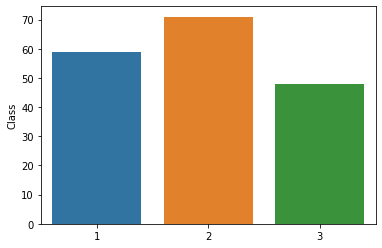

In [ ]:
value_counts = df.Class.value_counts()

# column 'Class' 분포 시각화 확인
sns.barplot(x = value_counts.index, y = value_counts)

## 스케일링
* 데이터의 스케일(Scale, 범위)을 맞추는 작업
* K-최근접 이웃은 거리 기반의 알고리즘이기 때문에 이러한 스케일 차이는 결과를 왜곡할 수 있음
* 스케일링은 이러한 문제를 해결하기 위해 인위적으로 각 컬럼(변수)이 비슷한 범위를 가지도록 만드는 작업
* 데이터를 **동등한 수준**에서 연산하게 함

#### 스케일링 종류
|종류|설명
|-|-|
|표준화 스케일링 Standarad Scaling|평균이 0이 되고, 표준편차가 1이 되도록 데이터를 고르게 분포시키는 데 사용|
|로버스트 스케일링 Robust Scaling|데이터에 아웃라이어가 존재하고, 그 영향력을 그대로 유지하고 싶을 때 사용|
|최소-최대 스케일링 Min-Max Scaling|데이터 분포의 특성을 최대한 그대로 유지하고 싶을 때 사용
|정규화 스케일링Normalizer Scaling|행 기준의 스케일링이 필요할 때 사용하나, 실제로 거의 사용하지 않음

- 평균을 사용하면 Outlier(이상치)에게 당한다!

#### 표준화 스케일링
> 데이터를 표준정규분포 형태로 변형

$x_i-mean(x)\over sd(x)$

* $x_i$ : 변수의 i번째 값
* $mean(x)$ : 해당 변수의 평균
* $sd(x)$ : 해당 변수의 표준편차


#### 로버스트 스케일링
> 사분위값을 이용하여 계산

$x_i-Q_2(x)\over Q_3(x)-Q_1(x)$

* $x_i$ : 변수의 i번째 값
* $Q_1(x)$ : 25% 지점
* $Q_2(x)$ : 50% 지점 (변수의 중윗값)
* $Q_3(x)$ : 75% 지점

#### 최소-최대 스케일링
> 최솟값, 최댓값을 사용하여 스케일링, 모든 컬럼에서 최댓값이 1, 최솟값이 0인 형태로 변환됨

$x_i-min(x)\over max(x)-min(x)$

* $x_i$ : 변수의 i번째 값
* $min(x)$ : 최솟값
* $max(x)$ : 최댓값

#### 스케일링 방식 선택 기준
* 아웃라이어의 유무 : 아웃라이어 영향이 클 시: `로버스트 스케일링` (4분위값 이용)
* 데이터의 기존 분포를 최대한 유지해야할 시 : `최소-최대 스케일링`
* 기존 데이터가 정규분포를 따르고 있고 아웃라이어가 없는 상황 : `표준화 스케일링`

#### 스케일링별 특징
|구분|결과물의 특징|
|-|-|
|표준화 스케일링|아웃라이어의 영향을 받음.<br>평균 0, 분산 1이 되게끔 분포시키기 때문에, **데이터의 기존 분포 형태가 사라지고** 정규분포를 따르는 결과물을 가져 옴|
|로버스트 스케일링|데이터에 아웃라이어가 존재할 때,<br> **아웃라이어의 영향을 받지 않음**.<br>변환된 데이터의 범위는 표준화 스케일링이나 최소-최대 스케일링보다 넓게 나타남|
|최소-최대 스케일링|아웃라이어의 영향을 받음.<br>위의 두 스케일러와 비교했을 때, **데이터의 기존 분포를 가장 있는 그대로 담아내며 스케일만 변화**시킴.<br>데이터의 범위는 0~1로 나타남|

#### 스케일링 적용 시 주의점
* 스케일링 대상에서 `종속변수`를 제외: 종속변수가 machine learning 학습 대상이다
* 스케일링 전 `train set`과 `test set`을 구분: modeling에 영향을 끼치는 것들은 미리 선정

## KNN 알고리즘 Data 처리 단계

1. 데이터 특성 보기 (`info`, `describe`)

2. 결측치 채워주기

3. 범주형 data > 더미 변수화

4. train set, test set 추출

5. Scailing: train set을 통해서 만들어진 scaler로 test set scailing

- Scailing: Outlier의 영향 줄이기, 범위에 따른 거리의 왜곡 줄이기

  - 훈련의 대상이 되는 데이터 vs. 시험의 대상이 되는 데이터: 독립돼 있어야 함

    - 만약 둘을 합쳐서 Scailing을 하면, scale의 기준 data(min-max, mean, 4분위 값)이 공유됨

    - train set을 대상으로만 scailing: scaler 학습 (train set 학습 scaler)

      - test set도 이미 학습된 scaler(train set 학습된 scaler)로 scailing을 진행

In [ ]:
# train set과 test set 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    # 'Class' column: 종속 변수
    df.drop('Class', axis=1),
    df.Class, test_size = 0.2, random_state = 100
)

In [ ]:
# 최대-최소 스케일러 사용: Outlier 심하지 않음
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()

# scaler 학습
mm_scaler.fit(X_train)

X_train_scaled = mm_scaler.transform(X_train)
X_train_scaled

In [ ]:
# scaler 학습 축약
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

X_test_scaled

array([[ 0.16052632,  0.26086957,  0.58823529,  0.56701031,  0.20289855,
         0.3057554 ,  0.26464208,  0.63265306,  0.29652997,  0.16170213,
         0.38793103,  0.54212454,  0.28673324],
       [ 0.64473684,  0.18379447,  0.68449198,  0.61340206,  0.27536232,
         0.53956835,  0.13665944,  0.71428571,  0.59305994,  1.11382979,
         0.01724138,  0.18681319,  0.24393723],
       [ 0.81315789,  0.14624506,  0.51336898,  0.31958763,  0.36231884,
         0.39568345,  0.42516269,  0.18367347,  0.3659306 ,  0.39574468,
         0.53448276,  0.56776557,  0.7146933 ],
       [ 0.24473684,  0.06916996,  0.5026738 ,  0.53608247,  0.44927536,
         0.82014388,  0.36225597, -0.08163265,  0.39116719,  0.20531915,
         0.37931034,  0.68131868,  0.43366619],
       [ 0.87105263,  0.18577075,  0.71657754,  0.74226804,  0.4057971 ,
         0.61151079,  0.18221258,  0.73469388,  0.72239748,  1.24680851,
         0.01724138,  0.25274725,  0.2724679 ],
       [ 0.53947368,  0.624505

## 모델링

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
pred = knn.predict(X_test_scaled)

pred

array([2, 3, 1, 2, 3, 3, 2, 3, 2, 1, 3, 1, 3, 3, 3, 1, 3, 1, 2, 1, 3, 1,
       3, 2, 1, 1, 2, 2, 2, 3, 3, 2, 1, 2, 3, 3])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.8888888888888888

In [ ]:
# Scailing되지 않은 data set(X_train) 사용
knn2 = KNeighborsClassifier()
knn2.fit(X_train, y_train)
pred2 = knn2.predict(X_test)

accuracy_score(y_test, pred2)

0.6388888888888888

### 하이퍼파라미터 튜닝(Hyperparameter tuning or optimization)
- parameter를 통해서 algorithms에 들어가는 values setting
  - 항상 같은 parameter value가 적용되는 게 맞을까?

`KNeighborsClassifier` : 분류 문제 알고리즘<br>
cf. `KNeighborsRegressor` : 회귀 문제 알고리즘
주요 패러미터(default)
- **`n_neighbors=5` : 예측에 참고할 이웃 수**
- `weights='uniform'` : 예측에 사용되는 가중치 함수로 기본값인 uniform은 모든 포인트에 동일한 가중치가 부여.
('uniform', 'distance', 사용자 정의 함수)
- `metric='minkowski'` : 거리 측정 기준 (DistanceMetric)
- `n_jobs=None` : 실행할 병렬 작업 수

> 별도로 지정해주지 않으면 기본값으로 반영<br>
> 알고리즘에 쓰이는 매개변수를 조정 = **Hyperparameter tuning**

In [ ]:
# hyperparameter tuning 함수화
def tuning(n: int) -> float:
  knn = KNeighborsClassifier(n_neighbors=n)
  # fit할 때 setting됨
  knn.fit(X_train_scaled, y_train)

  pred = knn.predict(X_test_scaled)
  score = accuracy_score(y_test, pred)
  return score

In [ ]:
# n_neighbors=1일 때 tuning된 pred로 accuracy_score() return값
tuning(1)

0.9166666666666666

In [ ]:
# 1부터 20까지 tuning() chck
# for i in range(1, 21):
#   print(tuning(i))
[tuning(i+1) for i in range(20)]

[0.9166666666666666,
 0.8611111111111112,
 0.9166666666666666,
 0.9166666666666666,
 0.8888888888888888,
 0.9166666666666666,
 0.9444444444444444,
 0.9166666666666666,
 0.8888888888888888,
 0.8888888888888888,
 0.9444444444444444,
 0.9444444444444444,
 0.9722222222222222,
 0.9444444444444444,
 0.9444444444444444,
 0.9444444444444444,
 0.9166666666666666,
 0.9722222222222222,
 0.9444444444444444,
 0.9722222222222222]

In [ ]:
k_list = [(i, tuning(i)) for i in range(1, 21)]

k_list

[(1, 0.9166666666666666),
 (2, 0.8611111111111112),
 (3, 0.9166666666666666),
 (4, 0.9166666666666666),
 (5, 0.8888888888888888),
 (6, 0.9166666666666666),
 (7, 0.9444444444444444),
 (8, 0.9166666666666666),
 (9, 0.8888888888888888),
 (10, 0.8888888888888888),
 (11, 0.9444444444444444),
 (12, 0.9444444444444444),
 (13, 0.9722222222222222),
 (14, 0.9444444444444444),
 (15, 0.9444444444444444),
 (16, 0.9444444444444444),
 (17, 0.9166666666666666),
 (18, 0.9722222222222222),
 (19, 0.9444444444444444),
 (20, 0.9722222222222222)]

In [ ]:
# accuracy_score 내림차순 정렬
sorted(k_list, key=lambda x: x[1], reverse=True)

[(13, 0.9722222222222222),
 (18, 0.9722222222222222),
 (20, 0.9722222222222222),
 (7, 0.9444444444444444),
 (11, 0.9444444444444444),
 (12, 0.9444444444444444),
 (14, 0.9444444444444444),
 (15, 0.9444444444444444),
 (16, 0.9444444444444444),
 (19, 0.9444444444444444),
 (1, 0.9166666666666666),
 (3, 0.9166666666666666),
 (4, 0.9166666666666666),
 (6, 0.9166666666666666),
 (8, 0.9166666666666666),
 (17, 0.9166666666666666),
 (5, 0.8888888888888888),
 (9, 0.8888888888888888),
 (10, 0.8888888888888888),
 (2, 0.8611111111111112)]

## KNN 알고리즘 이해
* KNN 알고리즘 : 새로운 데이터를 예측할 때, 거리를 기반으로 하여 인접한 데이터과 같은 종류로 분류
* 변수의 스케일 간의 격차가 클 경우, 산출되는 거리값이 왜곡될 수 있음
* 거리가 동점일 경우
  * 사이킷런 : 랜덤으로 분류함
  * n을 홀수로 하면 동점을 근본적으로 막을 수 있음
  * 그럼에도 짝수를 써야한다면 weights를 통해 가중치를 줌

## 연습
- 타이타닉 데이터에 KNN을 통해 분류 진행
- 스케일러(표준화, 로버스트, 최소-최대)별 결과 비교

## Titanic Data Modeling by KNN Algorithm

1. Data 수집

2. Data pre-processing

3. 모델 학습

4. 모델 평가

### 1. Data 수집

In [ ]:
url = 'https://raw.githubusercontent.com/dev-EthanJ/bigdata_16th/main/data/titanic_train.csv'
df_train = pd.read_csv(url)

df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0000,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0000,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0000,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0000,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0000,0,0,111369,30.0000,C148,C


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 2. Data pre-processing

In [ ]:
df_train.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [ ]:
# 너무 다양한 Data columns 'Cabin' drop
df_train = df_train.drop(['Cabin'], axis=1)

In [ ]:
# 'Embarked' 빈도 확인
df_train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [ ]:
df_train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [ ]:
# 가장 많은 S로 fillna
df_train.Embarked.fillna('S', inplace=True)

In [ ]:
df_train['Ticket'].nunique()

681

In [ ]:
# 'Ticket'도 무의미함 > drop
df_train.drop(columns=['Ticket'], inplace=True)

In [ ]:
# 정규 표현식을 통해 조건에 맞는 str을 추출
df_train['Title'] = df_train.Name.str.extract('([A-Za-z]+)\.')

df_train.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [ ]:
title_unique = df_train.Title.unique()

# 10개보다 적은 'Title' column의 item을 rarelist에 추가
rarelist = []
for t in title_unique:
    if list(df_train.Title).count(t) < 10:
        rarelist.append(t)

rarelist

['Don',
 'Rev',
 'Dr',
 'Mme',
 'Ms',
 'Major',
 'Lady',
 'Sir',
 'Mlle',
 'Col',
 'Capt',
 'Countess',
 'Jonkheer']

In [ ]:
# rarelist에 해당하는 'Title' item을 'Rare'로 변경
df_train.Title = df_train.Title.replace(rarelist, 'Rare')

# 'Title'의 'Rare' item이 27개 > 무시 할 만한 개수
df_train.Title.value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: Title, dtype: int64

In [ ]:
# 각 'Title'별 'Age'의 평균
title_age_mean = df_train.groupby('Title')['Age'].mean()

title_age_mean

Title
Master    4.5742
Miss     21.7740
Mr       32.3681
Mrs      35.8981
Rare     42.3846
Name: Age, dtype: float64

In [ ]:
# 'Age'의 결측치를 'Title'별 'Age'의 평균값으로 채움
# Title.unique list의 item t > isnull()=True 이면 title_age_mean[t]:'Title'별 'Age'의 평균으로 채운다
for t in df_train.Title.unique():
    df_train.loc[(df_train.Age.isnull()) & (df_train.Title == t), 'Age'] = title_age_mean[t]

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
 10  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [ ]:
for col_name in df_train.columns:
  print(col_name, df_train[col_name].nunique(), df_train[col_name].dtype)

PassengerId 891 int64
Survived 2 int64
Pclass 3 int64
Name 891 object
Sex 2 object
Age 93 float64
SibSp 7 int64
Parch 7 int64
Fare 248 float64
Embarked 3 object
Title 5 object


In [ ]:
df_train.PassengerId

0        1
1        2
2        3
3        4
4        5
      ... 
886    887
887    888
888    889
889    890
890    891
Name: PassengerId, Length: 891, dtype: int64

In [ ]:
# 'Name' column drop
df_train = df_train.drop('Name', axis=1)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
 9   Title        891 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


In [ ]:
df = df_train.copy()

df_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,male,22.0000,1,0,7.2500,S,Mr
1,2,1,1,female,38.0000,1,0,71.2833,C,Mrs
2,3,1,3,female,26.0000,0,0,7.9250,S,Miss
3,4,1,1,female,35.0000,1,0,53.1000,S,Mrs
4,5,0,3,male,35.0000,0,0,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0000,0,0,13.0000,S,Rare
887,888,1,1,female,19.0000,0,0,30.0000,S,Miss
888,889,0,3,female,21.7740,1,2,23.4500,S,Miss
889,890,1,1,male,26.0000,0,0,30.0000,C,Mr


- 범주형 data (`Dtype=object`)수치화

In [ ]:
df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
# 'Sex' column: male -> 0, female -> 1

df['Sex'] = df['Sex'].replace(['male', 'female'], [0, 1])

df.Sex.unique()

array([0, 1])

In [ ]:
df.Sex.value_counts()

0    577
1    314
Name: Sex, dtype: int64

In [ ]:
df.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [ ]:
# 'Embarked' column: S -> 0, C -> 1, Q -> 2

df.Embarked = df.Embarked.replace(['S', 'C', 'Q'], [0, 1, 2])

df.Embarked.unique()

array([0, 1, 2])

In [ ]:
df.Embarked.value_counts()

0    646
1    168
2     77
Name: Embarked, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    int64  
 9   Title        891 non-null    object 
dtypes: float64(2), int64(7), object(1)
memory usage: 69.7+ KB


In [ ]:
df.Title.value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: Title, dtype: int64

In [ ]:
title_key = list(df.Title.value_counts().index)

title_key

['Mr', 'Miss', 'Mrs', 'Master', 'Rare']

In [ ]:
# 순서대로 0, 1, 2, 3, 4
value_list = [0, 1, 2, 3, 4]

df.Title = df.Title.replace(title_key, value_list)

df['Title'].unique()

array([0, 2, 1, 3, 4])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    int64  
 9   Title        891 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 69.7 KB


In [ ]:
pd.options.display.float_format = '{:,.4f}'.format
df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000,891.0000
mean,446.0000,0.3838,2.3086,0.3524,29.7551,0.5230,0.3816,32.2042,0.3614,0.7407
std,257.3538,0.4866,0.8361,0.4780,13.2776,1.1027,0.8061,49.6934,0.6357,1.0521
min,1.0000,0.0000,1.0000,0.0000,0.4200,0.0000,0.0000,0.0000,0.0000,0.0000
25%,223.5000,0.0000,2.0000,0.0000,21.7740,0.0000,0.0000,7.9104,0.0000,0.0000
50%,446.0000,0.0000,3.0000,0.0000,30.0000,0.0000,0.0000,14.4542,0.0000,0.0000
75%,668.5000,1.0000,3.0000,1.0000,35.8981,1.0000,0.0000,31.0000,1.0000,1.0000
max,891.0000,1.0000,3.0000,1.0000,80.0000,8.0000,6.0000,512.3292,2.0000,4.0000


In [ ]:
df = df.drop('PassengerId', axis=1)

df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0000,1,0,7.2500,0,0
1,1,1,1,38.0000,1,0,71.2833,1,2
2,1,3,1,26.0000,0,0,7.9250,0,1
3,1,1,1,35.0000,1,0,53.1000,0,2
4,0,3,0,35.0000,0,0,8.0500,0,0
...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0000,0,0,13.0000,0,4
887,1,1,1,19.0000,0,0,30.0000,0,1
888,0,3,1,21.7740,1,2,23.4500,0,1
889,1,1,0,26.0000,0,0,30.0000,1,0


### 3. Model training

In [ ]:
# train set과 test set 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    # 'Survived' column: 종속 변수
    df.drop('Survived', axis=1),
    df.Survived, test_size = 0.2, random_state = 314
)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()

X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

X_test_scaled

array([[1.        , 0.        , 0.50364413, ..., 0.01512699, 1.        ,
        0.        ],
       [0.5       , 0.        , 0.09525006, ..., 0.07173122, 0.        ,
        0.75      ],
       [0.5       , 0.        , 0.42196532, ..., 0.05074862, 0.        ,
        0.        ],
       ...,
       [0.5       , 0.        , 0.23347575, ..., 0.02049464, 0.        ,
        0.        ],
       [0.5       , 0.        , 0.03242021, ..., 0.05074862, 0.        ,
        0.75      ],
       [1.        , 0.        , 0.32143755, ..., 0.01690807, 0.        ,
        0.        ]])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
pred = knn.predict(X_test_scaled)

pred

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0])

### 4. Model 평가

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, pred)

0.8324022346368715

In [ ]:
def tuning(n: int) -> float:
  knn = KNeighborsClassifier(n_neighbors=n)
  # fit할 때 setting됨
  knn.fit(X_train_scaled, y_train)

  pred = knn.predict(X_test_scaled)
  score = accuracy_score(y_test, pred)
  return score

In [ ]:
train_list = [[i, tuning(i)] for i in range(1,101)]

In [ ]:
sorted(train_list, key=lambda x: x[1], reverse=True)

[[14, 0.8603351955307262],
 [20, 0.8603351955307262],
 [21, 0.8603351955307262],
 [13, 0.8547486033519553],
 [16, 0.8547486033519553],
 [18, 0.8547486033519553],
 [23, 0.8547486033519553],
 [11, 0.8491620111731844],
 [15, 0.8491620111731844],
 [17, 0.8491620111731844],
 [19, 0.8491620111731844],
 [8, 0.8435754189944135],
 [10, 0.8435754189944135],
 [12, 0.8435754189944135],
 [22, 0.8435754189944135],
 [2, 0.8379888268156425],
 [4, 0.8379888268156425],
 [24, 0.8379888268156425],
 [25, 0.8379888268156425],
 [5, 0.8324022346368715],
 [9, 0.8324022346368715],
 [26, 0.8324022346368715],
 [27, 0.8324022346368715],
 [3, 0.8268156424581006],
 [6, 0.8268156424581006],
 [67, 0.8268156424581006],
 [69, 0.8268156424581006],
 [70, 0.8268156424581006],
 [71, 0.8268156424581006],
 [72, 0.8268156424581006],
 [7, 0.8212290502793296],
 [30, 0.8212290502793296],
 [31, 0.8212290502793296],
 [32, 0.8212290502793296],
 [33, 0.8212290502793296],
 [36, 0.8212290502793296],
 [38, 0.8212290502793296],
 [42, 0.8

In [ ]:
df_corr = df.corr()

df_corr

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
Survived,1.0000,-0.3385,0.5434,-0.0892,-0.0353,0.0816,0.2573,0.1068,0.4141
Pclass,-0.3385,1.0000,-0.1319,-0.3436,0.0831,0.0184,-0.5495,0.0457,-0.1848
Sex,0.5434,-0.1319,1.0000,-0.1174,0.1146,0.2455,0.1823,0.1166,0.5081
Age,-0.0892,-0.3436,-0.1174,1.0000,-0.2677,-0.1968,0.0911,-0.0168,-0.1266
SibSp,-0.0353,0.0831,0.1146,-0.2677,1.0000,0.4148,0.1597,-0.0600,0.2584
Parch,0.0816,0.0184,0.2455,-0.1968,0.4148,1.0000,0.2162,-0.0787,0.3036
Fare,0.2573,-0.5495,0.1823,0.0911,0.1597,0.2162,1.0000,0.0621,0.1373
Embarked,0.1068,0.0457,0.1166,-0.0168,-0.0600,-0.0787,0.0621,1.0000,0.0512
Title,0.4141,-0.1848,0.5081,-0.1266,0.2584,0.3036,0.1373,0.0512,1.0000


In [ ]:
import plotly.express as px

fig = px.imshow(df_corr,text_auto=True, color_continuous_scale='RdBu_r',title='상관관계 히트맵')
fig.show()

- 'Sex'와 'Title'이 각각 0.54, 0.41로 상관계수가 유의미하게 나왔다. 'Title'을 버릴 수도 있었지만, 빈도순으로 인코딩을 한 게 유의미한 행동이었다.

- 생각보다 'Age'가 매우 낮게 (0.1미만으로) 나와서 당황스러움. 노약자와 유소년층을 배려해서 구조하진 않았나보다... 

## Age Category 분류

In [ ]:
df_age = df.copy()

df_age['Weak'] = 0

df_age['Weak'].value_counts()

0    891
Name: Weak, dtype: int64

In [ ]:
df_age

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Weak
0,0,3,0,22.0000,1,0,7.2500,0,0,0
1,1,1,1,38.0000,1,0,71.2833,1,2,0
2,1,3,1,26.0000,0,0,7.9250,0,1,0
3,1,1,1,35.0000,1,0,53.1000,0,2,0
4,0,3,0,35.0000,0,0,8.0500,0,0,0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0000,0,0,13.0000,0,4,0
887,1,1,1,19.0000,0,0,30.0000,0,1,0
888,0,3,1,21.7740,1,2,23.4500,0,1,0
889,1,1,0,26.0000,0,0,30.0000,1,0,0


In [ ]:
for row in df_age.index:
  if (df_age.loc[row]['Age'] <= 12) or (df_age.loc[row]['Age'] >= 65):
    df_age.loc[row]['Weak'].replace(0, 1, inplace=True)

df_age['Weak'].value_counts()

AttributeError: ignored

In [ ]:
df['Weak'].value_counts()

0    891
Name: Weak, dtype: int64